# Apply weights to bins in K

/tmp/ipykernel_9747/1747484298.py:69: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(
/tmp/ipykernel_9747/1747484298.py:118: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  dmap = hp.smoothing(dmap, fwhm=np.radians(fwhm_deg), verbose=False)


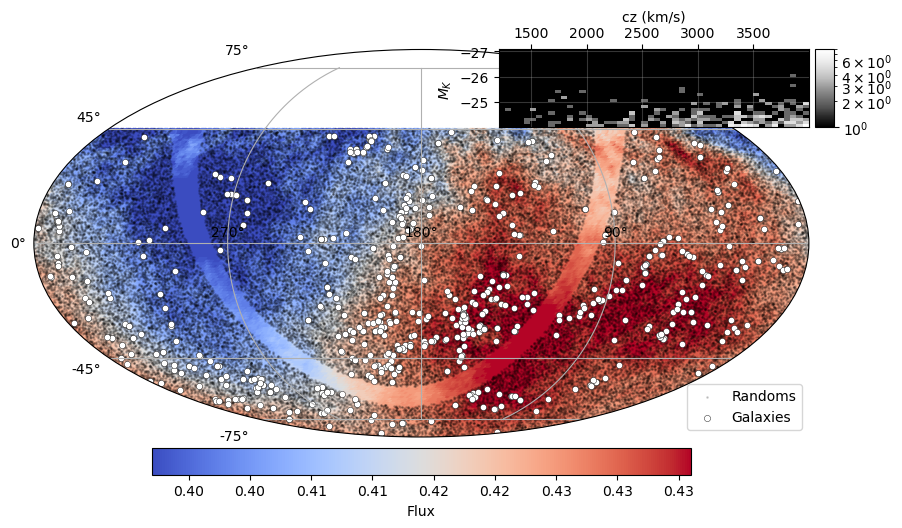

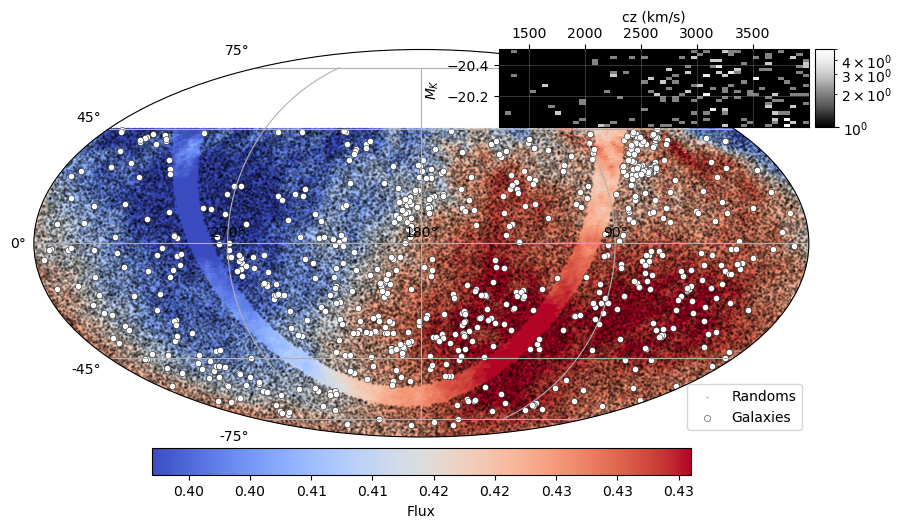

High K - suggested npatch = 12
Low K - suggested npatch = 14
Using: 200
The following patch numbers have no objects: {4, 6, 134, 8, 9, 10, 11, 139, 140, 144, 147, 148, 149, 152, 154, 27, 28, 155, 31, 32, 159, 162, 35, 37, 166, 176, 51, 52, 53, 181, 184, 185, 189, 193, 196, 71, 73, 76, 80, 81, 83, 84, 87, 91, 94, 96, 114, 118, 120, 124, 125, 126}
This may be a problem depending on your use case.
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='geom'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.
The following patch numbers have no objects: {4, 6, 134, 8, 9, 10, 11, 139, 140, 144, 147, 148, 149, 152, 154, 27, 28, 155, 31, 32, 159, 162, 35, 37, 166, 176, 51, 52, 53, 181, 184, 185, 189, 193, 196, 71, 73, 76, 80, 81, 83, 84, 87, 91, 94, 96, 114, 118, 120, 124, 125, 126}
This may be a problem depending on your use case.

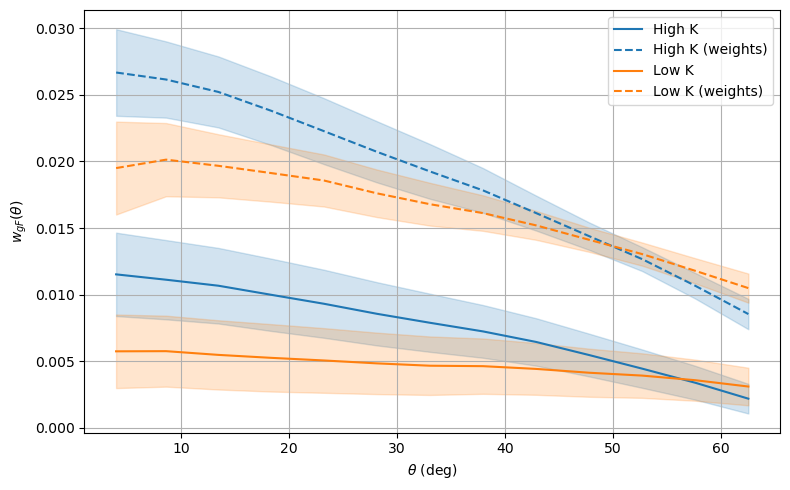

In [10]:
"""
Cleaned galaxy-flux correlation script with optional galaxy weights
(applies JF12 deflection map-derived weights to galaxies only).

Usage:
  - Edit file paths at the top if needed.
  - Run in an environment with treecorr, healpy, astropy, pandas, numpy, matplotlib.

Notes:
  - The `compute_weight_from_deflection` function is a placeholder: replace with
    the exact mapping you want from JF12 deflection to galaxy weight.
  - This script uses a deterministic subset of randoms and a fixed set of
    patch_centers so weighted/unweighted runs are consistent.

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import healpy as hp
import treecorr
from astropy.io import ascii


# --------------------------- User parameters ---------------------------
GLADE_FILE = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
DEFL_FILE = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"
FLUX_FILE = "../data/Auger/flux_a8_lb.dat"
PLOTS_DIR = "../plots"

FWHM_DEG = 30.0  # smoothing for deflection map
N_RAND_PER_GAL = 100
MIN_CZ = 1200
MAX_CZ = 4000
MK_CUT = -20.0
MAX_DEC = 45.0

# TreeCorr configuration (NK correlation)
TC_CONFIG = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "bootstrap_type": 'sample',
    "permutation": "sample",
    "n_bootstrap": 500
}


# --------------------------- Helper functions ---------------------------

def read_GLADE(cols_to_use, cz_min=MIN_CZ, dL_max=200, filename=GLADE_FILE):
    from get_masks import get_milkyway_mask

    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"]) & np.isfinite(chunk["RA"]) & np.isfinite(chunk["Dec"]) 
        filtered_chunks.append(chunk.loc[mask])

    df = pd.concat(filtered_chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    # apply Milky Way mask and dec cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec'] < MAX_DEC]

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=MAX_DEC):
    from get_masks import get_milkyway_mask

    rand_ra = np.random.uniform(0, 360, N_total * 3)
    rand_sindec = np.random.uniform(np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total * 3)
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError("Not enough random points generated after masking")
    return rand_ra, rand_dec


def load_deflection_map(defl_file=DEFL_FILE, fwhm_deg=FWHM_DEG):
    data = ascii.read(defl_file)
    pixel_ids = np.asarray(data['pixid'], dtype=int)
    deflection_data = np.asarray(data['deflection'], dtype=float)
    npix = int(np.max(pixel_ids)) + 1
    nside = hp.npix2nside(npix)
    dmap = np.full(npix, hp.UNSEEN, dtype=float)
    dmap[pixel_ids] = deflection_data
    if fwhm_deg and fwhm_deg > 0:
        dmap = hp.smoothing(dmap, fwhm=np.radians(fwhm_deg), verbose=False)
    return dmap, nside


def compute_weight_from_deflection(defl_values):
    """
    Convert deflection (degrees) into a weight for galaxies.
    Replace this mapping with the desired relation.
    Current placeholder: weight = 1 / (1 + defl) normalized to mean=1.
    """
    # Placeholder
    # w = 1.0 / (1.0 + np.abs(defl_values))

    # DGL Weighting Scheme
    sigma = np.mean(defl_values**2)**0.5
    w = 1. / ((sigma/20.)**2+defl_values**2)#**0.5
    w_a = w / np.mean(w)

    # Area weighting
    w = 1. / defl_values**2
    w_b = w / np.mean(w)

    # Alternative: robust inverse-variance weighting
    #eps = 1e-6
    #sigma0 = 0.1 * np.median(defl_values)   # floor = 10% of median (tune if needed)
    #w_raw = 1.0 / (defl_values**2 + sigma0**2)
    #w = w_raw / np.mean(w_raw)

    # normalize to mean=1 so total weight scale is comparable to unweighted
    # w = w / np.mean(w)
    return w_a, w_b


def plot_moll_deflection(dmap, fwhm_deg, galaxies=None, savepath=None):
    vmin = np.percentile(dmap[dmap != hp.UNSEEN], 5)
    vmax = np.percentile(dmap[dmap != hp.UNSEEN], 95)
    plt.figure(figsize=(10, 7))
    hp.mollview(dmap, title=f"Magnetic Deflection Map (FWHM={fwhm_deg}°)", cmap='plasma', rot=(180, 0, 0), min=vmin, max=vmax)
    hp.graticule(dpar=30, dmer=60, alpha=0.5)
    if galaxies is not None:
        theta = -np.radians(90 - galaxies['Dec'])
        phi = np.radians(galaxies['RA']) + np.pi
        hp.projscatter(theta, phi, s=20, color='white', edgecolor='k', linewidth=0.3)
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()   

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

def plot_catalogues(
    gxs,
    flux_ra, flux_dec, flux_val,
    rand_ra=None, rand_dec=None,
    savepath=None
):
    plt.figure(figsize=(10, 7))
    ax = plt.subplot(111, projection='mollweide')
    ax.grid(True)

    # Axes ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])
    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Background flux
    p5, p95 = np.percentile(flux_val, [5, 95])
    norm_flux = mcolors.Normalize(vmin=p5, vmax=p95)
    sc = ax.scatter(
        np.deg2rad(-flux_ra + 180.), np.deg2rad(flux_dec),
        c=flux_val, s=20, cmap='coolwarm',
        norm=norm_flux, edgecolor='none', alpha=1
    )
    cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal',
                             pad=0.02, fraction=0.05)
    cbar_flux.set_label("Flux")
    cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Randoms
    if rand_ra is not None and rand_dec is not None:
        ax.scatter(
            np.deg2rad(-rand_ra + 180.), np.deg2rad(rand_dec),
            s=1, color='black', alpha=0.15, label='Randoms'
        )

    # Galaxies
    ax.scatter(
        np.deg2rad(-gxs['RA'] + 180.), np.deg2rad(gxs['Dec']),
        s=20, color='white', edgecolor='k', linewidth=0.3,
        alpha=1, label='Galaxies'
    )

    plt.legend(loc='lower right')

    # ============================
    #   INSERTED INSET PLOT HERE
    # ============================
    inset = inset_axes(ax, width="40%", height="20%",
                       loc='upper right', borderpad=0)

    # SCATTER
    # inset.scatter(gxs['cz'], gxs['M_K'], s=10,
    #               color='tab:blue', alpha=0.7, edgecolor='none')

    # 2D HISTOGRAM
    hist = inset.hist2d(
        gxs['cz'], gxs['M_K'], bins=(50, 25),
        cmap='Greys_r',
        norm=mcolors.LogNorm()
    )

    inset.set_facecolor('k')
    # hist[3] is the QuadMesh that the colorbar needs
    cax = inset.inset_axes([1.02, 0.0, 0.06, 1.0]) 
    cbar_inset = plt.colorbar(hist[3], cax=cax, orientation='vertical', pad=0.0, fraction=.5)
    #cbar_inset = plt.colorbar(hist[3], ax=inset, orientation='vertical')

    inset.set_xlabel("cz (km/s)", fontsize=10)
    inset.set_ylabel(r"$M_K$", fontsize=10)
    inset.tick_params(labelsize=10)
    inset.invert_yaxis()  # optional: magnitudes brighter at top

    inset.xaxis.tick_top()
    inset.xaxis.set_label_position('top')

    inset.grid(alpha=0.3)

    # Tight layout + save
    #plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


def plot_results(meanr_list, xi_list, var_list, labels, colors, lss, savepath=None):
    plt.figure(figsize=(8, 5))
    for meanr, xi, varxi, lab, col, ls in zip(meanr_list, xi_list, var_list, labels, colors, lss):
        plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi), color=col, alpha=0.2)
        plt.plot(meanr, xi, color=col, label=lab, ls=ls)
    plt.xlabel(r'$\theta$ (deg)')
    plt.ylabel(r'$w_{gF}(\theta)$')
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


# --------------------------- Main processing ---------------------------

def main():
    # load galaxies
    cols = ["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"]
    gxs = read_GLADE(cols)
    if gxs['RA'].max() <= 2 * np.pi:
        gxs['RA'] = np.degrees(gxs['RA'])
        gxs['Dec'] = np.degrees(gxs['Dec'])

    gxs_cz = gxs[(gxs['cz'] >= MIN_CZ) & (gxs['cz'] <= MAX_CZ)].reset_index(drop=True)

    # load flux
    flux_cat = np.loadtxt(FLUX_FILE)
    flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]

    # load deflection map and assign to galaxies
    deflection_map, nside = load_deflection_map()
    theta = np.radians(90 - gxs_cz['Dec'])
    phi = np.radians(gxs_cz['RA'])
    pix = hp.ang2pix(nside, theta, phi)
    gal_defl = deflection_map[pix]
    valid = gal_defl != hp.UNSEEN
    gxs_cz = gxs_cz[valid].reset_index(drop=True)
    gal_defl = gal_defl[valid]

    # split galaxies by luminosity
    K_low_mask = (gxs_cz['M_K'] > -20.5) & (gxs_cz['M_K'] <= -20.)
    K_high_mask = (gxs_cz['M_K'] > -28.) & (gxs_cz['M_K'] <= -24.)
    gxs_cz_Klow = gxs_cz[K_low_mask].reset_index(drop=True)
    gxs_cz_Khigh = gxs_cz[K_high_mask].reset_index(drop=True)
    gal_defl_Klow = gal_defl[K_low_mask]
    gal_defl_Khigh = gal_defl[K_high_mask]

    # Apply same deflection mask to flux
    theta_f = np.radians(90 - flux_dec)
    phi_f = np.radians(flux_ra)
    pix_f = hp.ang2pix(nside, theta_f, phi_f)
    flux_defl = deflection_map[pix_f]
    valid_f = flux_defl != hp.UNSEEN
    flux_ra = flux_ra[valid_f]
    flux_dec = flux_dec[valid_f]
    flux_val = flux_val[valid_f]

    # generate randoms and apply same deflection mask
    rand_ra_all, rand_dec_all = generate_RanCat(len(gxs_cz) * N_RAND_PER_GAL)
    theta_r = np.radians(90 - rand_dec_all)
    pix_r = hp.ang2pix(nside, theta_r, np.radians(rand_ra_all))
    rand_defl = deflection_map[pix_r]
    valid_r = rand_defl != hp.UNSEEN
    rand_ra_all = rand_ra_all[valid_r]
    rand_dec_all = rand_dec_all[valid_r]
    if len(rand_ra_all) < (len(gxs_cz) * N_RAND_PER_GAL):
        raise RuntimeError("Not enough randoms after deflection mask")
    rand_ra_Khigh = rand_ra_all[:len(gxs_cz_Khigh) * N_RAND_PER_GAL]
    rand_dec_Khigh = rand_dec_all[:len(gxs_cz_Khigh) * N_RAND_PER_GAL]
    rand_ra_Klow = rand_ra_all[-len(gxs_cz_Klow) * N_RAND_PER_GAL:]
    rand_dec_Klow = rand_dec_all[-len(gxs_cz_Klow) * N_RAND_PER_GAL:]

    # plot catalogues after deflection mask
    plot_catalogues(gxs_cz_Khigh, flux_ra, flux_dec, flux_val, rand_ra_Khigh, rand_dec_Khigh,
        savepath=f'{PLOTS_DIR}/skymap_galaxies_deflection_Khigh.png')
    plot_catalogues(gxs_cz_Klow, flux_ra, flux_dec, flux_val, rand_ra_Klow, rand_dec_Klow,
        savepath=f'{PLOTS_DIR}/skymap_galaxies_deflection_Klow.png')


    # prepare arrays for TreeCorr
    gal_ra_Khigh = np.asarray(gxs_cz_Khigh['RA'], dtype=float)
    gal_dec_Khigh = np.asarray(gxs_cz_Khigh['Dec'], dtype=float)
    gal_ra_Klow = np.asarray(gxs_cz_Klow['RA'], dtype=float)
    gal_dec_Klow = np.asarray(gxs_cz_Klow['Dec'], dtype=float)
    rand_ra_Khigh = np.asarray(rand_ra_Khigh, dtype=float)
    rand_dec_Khigh = np.asarray(rand_dec_Khigh, dtype=float)
    rand_ra_Klow = np.asarray(rand_ra_Klow, dtype=float)
    rand_dec_Klow = np.asarray(rand_dec_Klow, dtype=float)
    flux_ra = np.asarray(flux_ra, dtype=float)
    flux_dec = np.asarray(flux_dec, dtype=float)
    flux_val = np.asarray(flux_val, dtype=float)

    # choose npatch reasonably
    N_g_Khigh = len(gal_ra_Khigh)
    N_g_Klow = len(gal_ra_Klow)
    suggest_npatch_Khigh = int(min(200, max(10, max(10, N_g_Khigh // 50))))
    npatch = 200
    print('High K - suggested npatch =', suggest_npatch_Khigh)
    base_Khigh = treecorr.Catalog(ra=np.concatenate([gal_ra_Khigh, rand_ra_Khigh]),
                             dec=np.concatenate([gal_dec_Khigh, rand_dec_Khigh]),
                             ra_units='deg', dec_units='deg', npatch=npatch)
    suggest_npatch_Klow = int(min(200, max(10, max(10, N_g_Klow // 50))))
    print('Low K - suggested npatch =', suggest_npatch_Klow)
    npatch = 200
    print('Using:', npatch)
    base_Klow = treecorr.Catalog(ra=np.concatenate([gal_ra_Klow, rand_ra_Klow]),
                             dec=np.concatenate([gal_dec_Klow, rand_dec_Klow]),
                             ra_units='deg', dec_units='deg', npatch=npatch)
    patch_centers_Khigh = base_Khigh.patch_centers
    patch_centers_Klow = base_Klow.patch_centers

    # compute weight array from deflection (galaxies only)
    w_gal_Khigh_a, w_gal_Khigh_b = compute_weight_from_deflection(gal_defl_Khigh)
    w_gal_Klow_a, w_gal_Klow_b = compute_weight_from_deflection(gal_defl_Klow)
    w_rand_Khigh = np.ones(len(rand_ra_Khigh), dtype=float)  # randoms get unit weight
    w_rand_Klow = np.ones(len(rand_ra_Klow), dtype=float)  # randoms get unit weight

    # define reusable compute function (fixed patch_centers)
    def compute_corr_fixed(gal_ra, gal_dec, w_g, \
                           rand_ra_fixed, rand_dec_fixed, w_r, \
                            flux_ra, flux_dec, flux_val, patch_centers):
        gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, \
                                ra_units='deg', dec_units='deg', w=w_g, patch_centers=patch_centers)
        rand_cat = treecorr.Catalog(ra=rand_ra_fixed, dec=rand_dec_fixed, \
                                    ra_units='deg', dec_units='deg', w=w_r, patch_centers=patch_centers)
        fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val, \
                                ra_units='deg', dec_units='deg')

        nk = treecorr.NKCorrelation(TC_CONFIG)
        rk = treecorr.NKCorrelation(TC_CONFIG)

        nk.process(gcat, fcat)
        rk.process(rand_cat, fcat)

        xi = nk.xi / rk.xi - 1
        varN = nk.varxi
        varw = varN / (rk.xi**2)
        return nk.meanr, xi, varw #nk, rk

    # run unweighted and weighted
    # K high
    meanr_u_Khigh, xi_u_Khigh, var_u_Khigh = compute_corr_fixed(gal_ra_Khigh, gal_dec_Khigh, None,
                                                                        rand_ra_Khigh, rand_dec_Khigh, None,
                                                                        flux_ra, flux_dec, flux_val, patch_centers_Khigh)

    meanr_wa_Khigh, xi_wa_Khigh, var_wa_Khigh = compute_corr_fixed(gal_ra_Khigh, gal_dec_Khigh, w_gal_Khigh_a,
                                                                        rand_ra_Khigh, rand_dec_Khigh, w_rand_Khigh,
                                                                        flux_ra, flux_dec, flux_val, patch_centers_Khigh)

    # K low
    meanr_u_Klow, xi_u_Klow, var_u_Klow = compute_corr_fixed(gal_ra_Klow, gal_dec_Klow, None,
                                                                        rand_ra_Klow, rand_dec_Klow, None,
                                                                        flux_ra, flux_dec, flux_val, patch_centers_Klow)     

    meanr_wa_Klow, xi_wa_Klow, var_wa_Klow = compute_corr_fixed(gal_ra_Klow, gal_dec_Klow, w_gal_Klow_a,
                                                                        rand_ra_Klow, rand_dec_Klow, w_rand_Klow,
                                                                        flux_ra, flux_dec, flux_val, patch_centers_Klow)
    

    # plotting
    meanr_list = [meanr_u_Khigh, meanr_wa_Khigh, meanr_u_Klow, meanr_wa_Klow]
    xi_list = [xi_u_Khigh, xi_wa_Khigh, xi_u_Klow, xi_wa_Klow]
    var_list = [var_u_Khigh, var_wa_Khigh, var_u_Klow, var_wa_Klow]
    labels = ["High K", "High K (weights)", "Low K", "Low K (weights)"]
    colors = ['C0', 'C0', 'C1', 'C1']
    lss = ['-', '--', '-', '--']

    plot_results(meanr_list, xi_list, var_list, labels, colors, lss, savepath=f"{PLOTS_DIR}/gal_flux_corrs_K.png")


if __name__ == '__main__':
    main()


### Bootstrap test


In [14]:
def read_GLADE(cols_to_use, cz_min=MIN_CZ, dL_max=200, filename=GLADE_FILE):
    from get_masks import get_milkyway_mask

    c = 299792.458
    chunksize = 200_000

    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
            filename,
            delim_whitespace=True,
            names=header,
            usecols=cols_to_use,
            skiprows=1,
            chunksize=chunksize):

        chunk = chunk[chunk["dist_flag"] != 0]
        chunk["cz"] = c * chunk["z_cmb"]
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"]) & np.isfinite(chunk["RA"]) & np.isfinite(chunk["Dec"]) 
        filtered_chunks.append(chunk.loc[mask])

    df = pd.concat(filtered_chunks, ignore_index=True)
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    # apply Milky Way mask and dec cut
    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec'] < MAX_DEC]

    return df


def generate_RanCat(N_total, dec_min=-90, dec_max=MAX_DEC):
    from get_masks import get_milkyway_mask

    rand_ra = np.random.uniform(0, 360, N_total * 3)
    rand_sindec = np.random.uniform(np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total * 3)
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError("Not enough random points generated after masking")
    return rand_ra, rand_dec

# Load Galaxies
cols = ["GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"]
gxs = read_GLADE(cols)
if gxs['RA'].max() <= 2 * np.pi:
    gxs['RA'] = np.degrees(gxs['RA'])
    gxs['Dec'] = np.degrees(gxs['Dec'])

gxs_cz = gxs[(gxs['cz'] >= MIN_CZ) & (gxs['cz'] <= MAX_CZ)].reset_index(drop=True)
gal_ra = np.asarray(gxs_cz['RA'], dtype=float)
gal_dec = np.asarray(gxs_cz['Dec'], dtype=float)

# load flux
FLUX_FILE = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(FLUX_FILE)
flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]

# Generate Randoms
rand_ra, rand_dec = generate_RanCat(len(gxs_cz) * N_RAND_PER_GAL)



/tmp/ipykernel_9747/1127080447.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Testing npatch: [10, 20, 40, 80, 160]

Running npatch = 10
[npatch=10] galaxies per patch: min=111, median=828.0, mean=806.7
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='geom'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.

Running npatch = 20
[npatch=20] galaxies per patch: min=35, median=209.0, mean=403.4
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='geom'.  See the docs for details about this option.  It may become the new default value in a future version.
Set cross_patch_weight='simple' explicitly to suppress this message.

Running npatch = 40
[npatch=40] galaxies per patch: min=4, median=59.0, mean=206.8
Using the default cross_patch_weight='simple' may be less accurate than using cross_patch_weight='geom'.  See the docs for details about this option.  

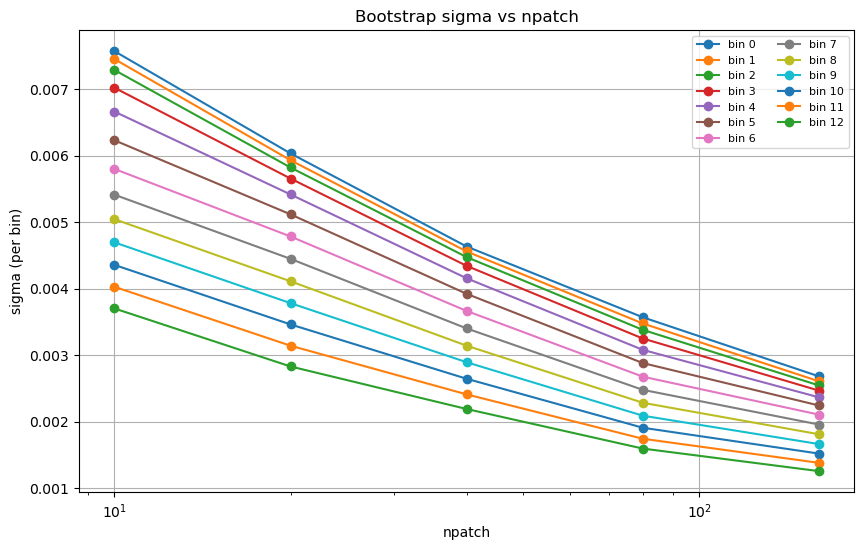

Fractional changes per bin between successive npatch values:
10 -> 20: max frac change = 0.236, median = 0.195
20 -> 40: max frac change = 0.236, median = 0.233
40 -> 80: max frac change = 0.279, median = 0.270
80 -> 160: max frac change = 0.250, median = 0.213
Corr Frobenius diff 10->20: 0.1125 (normed 0.0091)
Corr Frobenius diff 20->40: 0.1538 (normed 0.0125)
Corr Frobenius diff 40->80: 0.2531 (normed 0.0208)
Corr Frobenius diff 80->160: 0.0906 (normed 0.0075)


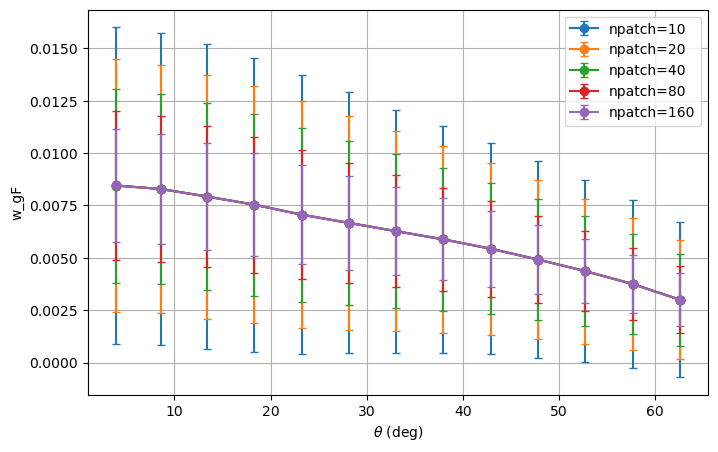

In [ ]:
import numpy as np
import treecorr
import matplotlib.pyplot as plt

# ========== Patch occupancy helper ==========

def patch_occupancy(ra, dec, patch_centers):
    """
    Compute how many (ra,dec) points fall into each TreeCorr patch.
    Uses the same logic: assign to nearest patch center on the sphere.
    """
    # Convert points to radians
    ra = np.radians(ra)
    dec = np.radians(dec)

    # Convert patch_centers (list of (ra,dec) in radians)
    pc = np.array(patch_centers)   # shape (npatch, 2)
    pc_ra = pc[:,0]
    pc_dec = pc[:,1]

    # Convert all to 3D unit vectors
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    pts = np.vstack([x,y,z]).T        # (N, 3)

    xc = np.cos(pc_dec) * np.cos(pc_ra)
    yc = np.cos(pc_dec) * np.sin(pc_ra)
    zc = np.sin(pc_dec)
    centers = np.vstack([xc,yc,zc]).T  # (npatch, 3)

    # Compute dot products (cos theta) between every point and every center
    # shape (N_points, npatch)
    dots = pts @ centers.T

    # nearest patch = max dot product
    patch_ids = np.argmax(dots, axis=1)

    # return counts
    _, counts = np.unique(patch_ids, return_counts=True)
    return counts


# ========== TreeCorr setup template ==========

TC_TEMPLATE = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "permutation": 'sample',
    "cross_patch_weight": 'geom',
    "n_bootstrap": 1500
}

# Your existing read_GLADE / generate_RanCat unchanged...


# ========== Modified run_for_npatch WITH patch occupancy reporting ==========

def run_for_npatch(npatch, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, tc_template):
    # Build base catalog (to get patch_centers)
    base = treecorr.Catalog(
        ra=np.concatenate([gal_ra, rand_ra]),
        dec=np.concatenate([gal_dec, rand_dec]),
        ra_units='deg', dec_units='deg', npatch=npatch
    )
    patch_centers = base.patch_centers

    # ---- PATCH OCCUPANCY ----
    counts_gal = patch_occupancy(gal_ra, gal_dec, patch_centers)
    minc, medc, meanc = counts_gal.min(), np.median(counts_gal), counts_gal.mean()
    print(f"[npatch={npatch}] galaxies per patch: min={minc}, median={medc:.1f}, mean={meanc:.1f}")

    if medc < 10:
        print(f"⚠️ WARNING: median={medc:.1f} < 10 galaxies/patch → bootstrap may be noisy/unreliable")

    # Make catalogs using the same patch_centers
    gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
    rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val, ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(tc_template)
    rk = treecorr.NKCorrelation(tc_template)

    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    xi = nk.xi / rk.xi - 1.0
    varw = nk.varxi / (rk.xi**2)

    covN = nk.cov
    denom = np.outer(rk.xi, rk.xi)
    covw = covN / denom

    return {
        "npatch": npatch,
        "meanr": nk.meanr,
        "xi": xi.copy(),
        "sigma": np.sqrt(varw),
        "covw": covw.copy(),
        "patch_counts": counts_gal,
        "patch_min": minc,
        "patch_med": medc,
        "patch_mean": meanc
    }


# ========== Convergence test wrapper ==========

def convergence_test(npatch_list, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, tc_template):
    results = []
    for npatch in npatch_list:
        print("\n============================")
        print("Running npatch =", npatch)
        res = run_for_npatch(npatch, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, tc_template)
        results.append(res)
    return results


# === Load your galaxies, flux, randoms as before ===
# gxs = read_GLADE(...)
# rand_ra, rand_dec = generate_RanCat(...)
# etc.


# ========== CHOOSE npatch LIST ==========

N_g = len(gal_ra)
max_sane = max(10, min(200, N_g // 5))
npatch_list = [10, 20, 40, 80, 160]
npatch_list = [n for n in npatch_list if n <= max_sane]

print("Testing npatch:", npatch_list)

results = convergence_test(npatch_list, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, TC_TEMPLATE)


# ========== Diagnostics & Plots (unchanged) ==========

nbins = len(results[0]["meanr"])
meanr = results[0]["meanr"]

plt.figure(figsize=(10,6))
for ibin in range(nbins):
    sigs = [r["sigma"][ibin] for r in results]
    plt.plot(npatch_list, sigs, marker='o', label=f'bin {ibin}')
plt.xscale('log')
plt.xlabel('npatch')
plt.ylabel('sigma (per bin)')
plt.title('Bootstrap sigma vs npatch')
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()


print("Fractional changes per bin between successive npatch values:")
for i in range(len(results)-1):
    r1 = results[i]; r2 = results[i+1]
    frac = np.abs(r2["sigma"] - r1["sigma"]) / r1["sigma"]
    print(f"{r1['npatch']} -> {r2['npatch']}: max frac change = {np.nanmax(frac):.3f}, median = {np.nanmedian(frac):.3f}")


def corr_from_cov(cov):
    diag = np.sqrt(np.diag(cov))
    return cov / np.outer(diag, diag)


for i in range(len(results)-1):
    c1 = corr_from_cov(results[i]["covw"])
    c2 = corr_from_cov(results[i+1]["covw"])
    diff = c2 - c1
    frob = np.linalg.norm(diff, 'fro')
    norm = np.linalg.norm(c1, 'fro')
    print(f"Corr Frobenius diff {results[i]['npatch']}->{results[i+1]['npatch']}: {frob:.4f} (normed {frob/norm:.4f})")


plt.figure(figsize=(8,5))
for r,label in zip(results, [f"npatch={r['npatch']}" for r in results]):
    plt.errorbar(r["meanr"], r["xi"], yerr=r["sigma"], marker='o', capsize=3, label=label)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel('w_gF')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Convergence test script (paste into your notebook)
import numpy as np
import treecorr
import matplotlib.pyplot as plt
import warnings

# ========== USER CONFIG ==========
# Paths / parameters expected to be defined in your notebook/environment:
# - GLADE_FILE, FLUX_FILE, MIN_CZ, MAX_CZ, N_RAND_PER_GAL, MAX_DEC, PLOTS_DIR (you already have those)
# - read_GLADE(cols) and generate_RanCat(N) should be defined as in your script.
#
# If not, define them above this cell. The script below will use gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val.

# TreeCorr config template (we'll override var_method per test)
TC_BASE = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    # use geometric cross-patch weighting (recommended)
    "cross_patch_weight": "geom",
    # permutation used by TreeCorr for bootstrap/jackknife (sample => with replacement)
    "permutation": 'sample',
    # n_bootstrap will be set for bootstrap case
}

# run settings
TARGET_PER_PATCH = 30        # target median galaxies per patch (tweak between 20-50)
MIN_PATCH = 4                # minimum allowed npatch
MAX_PATCH = 200              # cap
N_BOOTSTRAP = 1500           # bootstrap trials
SEED = 42                    # reproducibility for randoms/patch centers where applicable

# ========== Helper: convert RA/Dec to unit vectors and assign patches ==========
def radec_to_unitvec(ra_deg, dec_deg):
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.vstack([x, y, z]).T  # shape (N,3)

def patch_occupancy(ra_deg, dec_deg, patch_centers):
    """
    Assign each (ra,dec) to nearest patch center (patch_centers is array-like shape (npatch,2) in radians),
    returns counts per patch of assigned points.
    """
    pts = radec_to_unitvec(ra_deg, dec_deg)          # (N,3)
    pc = np.array(patch_centers)                     # (npatch,2) in radians
    pc_ra = pc[:,0]; pc_dec = pc[:,1]
    centers = radec_to_unitvec(np.degrees(pc_ra), np.degrees(pc_dec))  # (npatch,3)
    dots = pts @ centers.T                            # (N, npatch)
    patch_ids = np.argmax(dots, axis=1)
    _, counts = np.unique(patch_ids, return_counts=True)
    # If some patches have zero counts, NP.unique returns fewer entries; create full counts:
    full_counts = np.zeros(len(centers), dtype=int)
    ids, cts = np.unique(patch_ids, return_counts=True)
    full_counts[ids] = cts
    return full_counts

# ========== Helper: auto-suggest npatch candidates ==========
def suggest_npatch_candidates(N_g, target_per_patch=TARGET_PER_PATCH, min_npatch=MIN_PATCH, max_npatch=MAX_PATCH):
    if N_g <= 0:
        return [min_npatch]
    npatch0 = max(min_npatch, min(max_npatch, int(round(N_g / target_per_patch))))
    # build a small grid around npatch0 while keeping it within bounds
    candidates = sorted(set([
        max(min_npatch, npatch0 // 2),
        max(min_npatch, npatch0),
        min(max_npatch, max(min_npatch, npatch0 * 2)),
        min(max_npatch, max(min_npatch, npatch0 * 4))
    ]))
    # filter unrealistic very-large counts and duplicates
    candidates = [int(c) for c in candidates if c >= min_npatch and c <= max_npatch]
    return candidates

# ========== Core runner: builds base patch centers, runs NK/RK, returns diagnostics ==========
def run_for_npatch(npatch, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, method="bootstrap", tc_base=TC_BASE, n_bootstrap=N_BOOTSTRAP):
    """
    method: "bootstrap" or "jackknife" or "shot"
    returns dict with meanr, xi, sigma, covw, patch_counts and occupancy stats.
    """
    tc = dict(tc_base)  # copy
    if method == "bootstrap":
        tc["var_method"] = "bootstrap"
        tc["n_bootstrap"] = int(n_bootstrap)
    elif method == "jackknife":
        tc["var_method"] = "jackknife"
    elif method == "shot":
        tc["var_method"] = "shot"
    else:
        raise ValueError("method must be 'bootstrap','jackknife' or 'shot'")

    # Build base catalog to get patch_centers (guarantees deterministic patch centers for given seed)
    base = treecorr.Catalog(
        ra=np.concatenate([gal_ra, rand_ra]),
        dec=np.concatenate([gal_dec, rand_dec]),
        ra_units='deg', dec_units='deg', npatch=int(npatch)
    )
    patch_centers = base.patch_centers  # array shape (npatch, 2) in radians

    # occupancy
    counts_g = patch_occupancy(gal_ra, gal_dec, patch_centers)
    minc, medc, meanc = counts_g.min(), np.median(counts_g), counts_g.mean()
    print(f"[{method}] npatch={npatch} : gal per patch min={minc}, med={medc:.1f}, mean={meanc:.1f}")
    if medc < 10:
        warnings.warn(f"Median galaxies per patch {medc:.1f} < 10. Bootstrap/jackknife may be unreliable.", RuntimeWarning)

    # Build catalogs with identical patch_centers for galaxy/random, but NOT flux
    gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
    rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='deg', dec_units='deg', patch_centers=patch_centers)
    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val, ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(tc)
    rk = treecorr.NKCorrelation(tc)

    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    # estimator w = N/R - 1
    xi = nk.xi / rk.xi - 1.0

    # TreeCorr stores cov/covariances for N; convert to w by dividing by R_i R_j
    # var for w diagonal:
    varw = nk.varxi / (rk.xi**2)

    covN = nk.cov
    denom = np.outer(rk.xi, rk.xi)
    # guard against zero denom
    denom[denom == 0] = np.nan
    covw = covN / denom

    return {
        "method": method,
        "npatch": int(npatch),
        "patch_centers": patch_centers,
        "patch_counts": counts_g,
        "patch_min": int(minc), "patch_med": float(medc), "patch_mean": float(meanc),
        "meanr": nk.meanr.copy(),
        "xi": xi.copy(),
        "sigma": np.sqrt(varw),
        "covw": covw.copy()
    }

# ========== High-level convergence test: tries candidate npatch and both methods ==========
def convergence_scan(gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val,
                     methods=("bootstrap","jackknife"), target_per_patch=TARGET_PER_PATCH):
    N_g = len(gal_ra)
    npatch_candidates = suggest_npatch_candidates(N_g, target_per_patch=target_per_patch)
    print("Auto npatch candidates:", npatch_candidates)
    all_results = []
    for method in methods:
        print("\n==== Running method:", method, "====")
        for npatch in npatch_candidates:
            res = run_for_npatch(npatch, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val,
                                method=method, tc_base=TC_BASE, n_bootstrap=N_BOOTSTRAP)
            all_results.append(res)
    return all_results

# ========== Diagnostics: compare successive npatch for a given method ==========
def analyze_results(results):
    # group by method
    by_method = {}
    for r in results:
        by_method.setdefault(r["method"], []).append(r)
    recommendations = {}
    for method, reslist in by_method.items():
        reslist = sorted(reslist, key=lambda r: r["npatch"])
        # compute per-pair fractional changes and cov Frobenius norms
        nres = len(reslist)
        print("\n--- Analysis for", method, "---")
        for i in range(nres-1):
            r1 = reslist[i]; r2 = reslist[i+1]
            sigma1 = r1["sigma"]; sigma2 = r2["sigma"]
            # avoid divide-by-zero
            frac = np.abs(sigma2 - sigma1) / np.where(sigma1==0, np.nan, sigma1)
            max_frac = np.nanmax(frac); med_frac = np.nanmedian(frac)
            print(f"{r1['npatch']} -> {r2['npatch']}: max frac change = {max_frac:.3f}, median = {med_frac:.3f}")

            # covariance correlation matrices
            def corr_from_cov(cov):
                diag = np.sqrt(np.diag(cov))
                denom = np.outer(diag, diag)
                denom[denom==0] = np.nan
                return cov / denom
            c1 = corr_from_cov(r1["covw"])
            c2 = corr_from_cov(r2["covw"])
            # compute Frobenius of diff normalized by norm of c1
            diff = np.nan_to_num(c2 - c1)
            frob = np.linalg.norm(diff, 'fro')
            norm = np.linalg.norm(np.nan_to_num(c1), 'fro')
            print(f"Corr Frobenius diff {r1['npatch']}->{r2['npatch']}: {frob:.4f} (normed {frob/(norm+1e-12):.4f})")

        # recommend best npatch for this method: choose the largest npatch whose median fractional change to previous is < 0.10
        chosen = None
        for i in range(nres-1):
            r1 = reslist[i]; r2 = reslist[i+1]
            frac = np.abs(r2["sigma"] - r1["sigma"]) / np.where(r1["sigma"]==0, np.nan, r1["sigma"])
            if np.nanmedian(frac) < 0.10:
                chosen = r2["npatch"]
        if chosen is None:
            # fallback: pick npatch with patch_med >= target_per_patch and largest npatch
            good = [r for r in reslist if r["patch_med"] >= TARGET_PER_PATCH]
            chosen = good[-1]["npatch"] if len(good)>0 else reslist[0]["npatch"]
        recommendations[method] = chosen
        print(f"Recommendation for {method}: npatch = {chosen}")
    return recommendations

# ========== Example usage: run the scan and analyze ==========
# Provide your data arrays here (these should be the same variables you've been using)
# Make sure they are numpy arrays:
# gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val

# --- --- ----
# If you already have gxs_cz, flux_cat and generated rand_ra/rand_dec:
# gal_ra = np.asarray(gxs_cz['RA'], dtype=float)
# gal_dec = np.asarray(gxs_cz['Dec'], dtype=float)
# flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]
# rand_ra, rand_dec = generate_RanCat(len(gxs_cz) * N_RAND_PER_GAL)
# --- --- ----

#Run (uncomment and execute when arrays exist)
results = convergence_scan(gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val,
                           methods=("bootstrap","jackknife"), target_per_patch=TARGET_PER_PATCH)
recommendations = analyze_results(results)

# Optional: produce the same diagnostic plots you used previously (sigma vs npatch, xi with errors) --
# you can reuse the plotting code from earlier cells by collecting results per method/npatch.


Auto npatch candidates: [100, 200]

==== Running method: bootstrap ====
[bootstrap] npatch=100 : gal per patch min=0, med=19.5, mean=80.7
[bootstrap] npatch=200 : gal per patch min=0, med=7.0, mean=40.3
The following patch numbers have no objects: {52}
This may be a problem depending on your use case.


/tmp/ipykernel_9747/2456732744.py:110: RuntimeWarning: Median galaxies per patch 7.0 < 10. Bootstrap/jackknife may be unreliable.
  warnings.warn(f"Median galaxies per patch {medc:.1f} < 10. Bootstrap/jackknife may be unreliable.", RuntimeWarning)



==== Running method: jackknife ====
[jackknife] npatch=100 : gal per patch min=0, med=16.0, mean=80.7
[jackknife] npatch=200 : gal per patch min=0, med=7.0, mean=40.3
The following patch numbers have no objects: {54}
This may be a problem depending on your use case.

--- Analysis for bootstrap ---
100 -> 200: max frac change = 0.285, median = 0.244
Corr Frobenius diff 100->200: 0.1945 (normed 0.0162)
Recommendation for bootstrap: npatch = 100

--- Analysis for jackknife ---
100 -> 200: max frac change = 0.248, median = 0.232
Corr Frobenius diff 100->200: 0.0600 (normed 0.0050)
Recommendation for jackknife: npatch = 100


npatch candidates: [8, 12, 16, 20, 30]

--- Building equal-occupancy patches: k = 8

== Running jackknife with npatch=8 ==
[jackknife] npatch=8 : gal per patch min=654, med=1082.5, mean=1008.4

== Running bootstrap with npatch=8 ==
[bootstrap] npatch=8 : gal per patch min=654, med=1082.5, mean=1008.4

--- Building equal-occupancy patches: k = 12

== Running jackknife with npatch=12 ==
[jackknife] npatch=12 : gal per patch min=393, med=589.0, mean=672.2

== Running bootstrap with npatch=12 ==
[bootstrap] npatch=12 : gal per patch min=393, med=589.0, mean=672.2

--- Building equal-occupancy patches: k = 16

== Running jackknife with npatch=16 ==
[jackknife] npatch=16 : gal per patch min=317, med=461.5, mean=504.2

== Running bootstrap with npatch=16 ==
[bootstrap] npatch=16 : gal per patch min=317, med=461.5, mean=504.2

--- Building equal-occupancy patches: k = 20

== Running jackknife with npatch=20 ==
[jackknife] npatch=20 : gal per patch min=208, med=376.5, mean=403.4

== Running boo

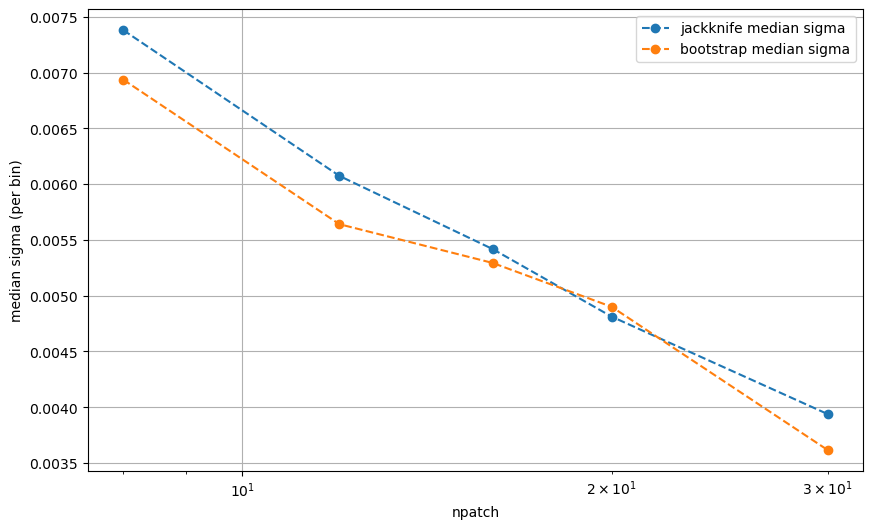

In [23]:
# === equal-occupancy NK convergence script (TreeCorr-compatible) ===
# Paste this into your notebook after defining:
#   - read_GLADE(cols)
#   - generate_RanCat(N)
#   - GLADE_FILE, FLUX_FILE, MIN_CZ, MAX_CZ, N_RAND_PER_GAL, etc.
# It expects numpy arrays: gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val

import numpy as np
import treecorr
import matplotlib.pyplot as plt
import warnings

# -------------------------
# TreeCorr base config (NK)
# -------------------------
TC_BASE = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "cross_patch_weight": "geom",   # recommended for patch resampling
    "permutation": "sample"         # sample means bootstrap-like sampling of patches
}

# -------------------------
# Spherical utilities
# -------------------------
def radec_to_unitvec(ra_deg, dec_deg):
    """Return Nx3 array of unit vectors for RA/Dec in degrees."""
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.vstack([x, y, z]).T

def unitvec_to_radec(vecs):
    """vecs shape (M,3) -> (ra_rad_array, dec_rad_array)"""
    x = vecs[:,0]; y = vecs[:,1]; z = vecs[:,2]
    dec = np.arcsin(np.clip(z, -1, 1))
    ra = np.arctan2(y, x) % (2*np.pi)
    return ra, dec

# -------------------------
# Robust spherical k-means
# -------------------------
def spherical_kmeans(ra_deg, dec_deg, k, max_iter=200, tol=1e-6, seed=0):
    """
    Perform spherical k-means (on 3D unit vectors).
    Returns patch_centers as an (k,2) contiguous float array of (ra_rad, dec_rad),
    and counts per cluster (length k).
    """
    rng = np.random.RandomState(seed)
    pts = radec_to_unitvec(ra_deg, dec_deg)   # (N,3)
    N = pts.shape[0]
    if k <= 0:
        raise ValueError("k must be > 0")

    # init centers: pick k distinct points (or random with replacement if N<k)
    if N >= k:
        init_idx = rng.choice(N, size=k, replace=False)
    else:
        # fallback: repeat indices
        init_idx = np.concatenate([np.arange(N), rng.randint(0, N, size=k-N)])
    centers = pts[init_idx].astype(float)
    centers /= np.linalg.norm(centers, axis=1)[:,None]

    for it in range(max_iter):
        dots = pts @ centers.T           # (N,k)
        labels = np.argmax(dots, axis=1) # nearest center
        new_centers = np.zeros_like(centers)
        counts = np.zeros(k, dtype=int)
        for j in range(k):
            sel = (labels == j)
            cnt = sel.sum()
            counts[j] = cnt
            if cnt > 0:
                v = pts[sel].sum(axis=0)
                norm = np.linalg.norm(v)
                if norm > 0:
                    new_centers[j] = v / norm
                else:
                    new_centers[j] = pts[rng.randint(0, N)]
            else:
                # empty cluster: reinit to random point (should be rare if k chosen well)
                new_centers[j] = pts[rng.randint(0, N)]
        diff = np.linalg.norm(new_centers - centers, axis=1).max()
        centers = new_centers
        if diff < tol:
            break

    ra_cent, dec_cent = unitvec_to_radec(centers)
    patch_centers = np.ascontiguousarray(np.column_stack([ra_cent, dec_cent]).astype(float))  # radians
    return patch_centers, counts

# -------------------------
# Assign points to provided patch_centers (TreeCorr-compatible)
# -------------------------
def patch_occupancy_from_centers(ra_deg, dec_deg, patch_centers):
    """
    Return (counts_array, set_of_empty_cluster_indices)
    patch_centers must be (k,2) radians contiguous float array.
    """
    pts = radec_to_unitvec(ra_deg, dec_deg)  # (N,3)
    pc = np.ascontiguousarray(np.asarray(patch_centers, dtype=float))
    if pc.ndim != 2 or pc.shape[1] != 2:
        raise ValueError(f"patch_centers must be shape (k,2) radians; got {pc.shape}")
    centers_vec = radec_to_unitvec(np.degrees(pc[:,0]), np.degrees(pc[:,1]))  # (k,3)
    dots = pts @ centers_vec.T
    labels = np.argmax(dots, axis=1)
    ids, cts = np.unique(labels, return_counts=True)
    full = np.zeros(pc.shape[0], dtype=int)
    full[ids] = cts
    empty = set(np.where(full == 0)[0].tolist())
    return full, empty

# -------------------------
# NK runner that accepts patch_centers array
# -------------------------
def run_with_patch_centers(patch_centers, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, method="jackknife", n_bootstrap=1500):
    tc = dict(TC_BASE)
    if method == "bootstrap":
        tc["var_method"] = "bootstrap"
        tc["n_bootstrap"] = int(n_bootstrap)
    elif method == "jackknife":
        tc["var_method"] = "jackknife"
    elif method == "shot":
        tc["var_method"] = "shot"
    else:
        raise ValueError("method must be 'bootstrap','jackknife' or 'shot'")

    # patch_centers comes in as (k,2) array of (ra_rad, dec_rad) from spherical_kmeans
    patch_centers = np.ascontiguousarray(np.asarray(patch_centers, dtype=float).reshape(-1,2))

    # Convert (ra_rad,dec_rad) -> (x,y,z) unit vectors as TreeCorr expects for spherical coords
    pc_ra_rad = patch_centers[:, 0]
    pc_dec_rad = patch_centers[:, 1]
    # Convert to degrees because radec_to_unitvec helper expects degrees
    centers_cart = radec_to_unitvec(np.degrees(pc_ra_rad), np.degrees(pc_dec_rad))  # shape (k,3)

    # debug: confirm shapes/types (comment out after verifying)
    # print("patch_centers (rad) shape:", patch_centers.shape, "dtype:", patch_centers.dtype)
    # print("centers_cart (x,y,z) shape:", centers_cart.shape, "dtype:", centers_cart.dtype)

    counts, empty = patch_occupancy_from_centers(gal_ra, gal_dec, patch_centers)
    minc, medc, meanc = int(counts.min()), float(np.median(counts)), float(counts.mean())
    print(f"[{method}] npatch={len(patch_centers)} : gal per patch min={minc}, med={medc:.1f}, mean={meanc:.1f}")
    if len(empty) > 0:
        print("WARNING: Some patch numbers do not contain any objects!")
        print("The following patch numbers have no objects:", empty)
    if medc < 10:
        warnings.warn(f"Median galaxies per patch {medc:.1f} < 10. Resampling may be unreliable.", RuntimeWarning)

    # Make catalogs with explicit patch_centers for galaxy/random; flux has no patches
    # NOTE: pass centers_cart (k,3) here — TreeCorr expects 3 columns for spherical coords
    gcat = treecorr.Catalog(ra=gal_ra, dec=gal_dec, ra_units='deg', dec_units='deg', patch_centers=centers_cart)
    rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='deg', dec_units='deg', patch_centers=centers_cart)
    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val, ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(tc)
    rk = treecorr.NKCorrelation(tc)

    nk.process(gcat, fcat)
    rk.process(rcat, fcat)

    xi = nk.xi / rk.xi - 1.0
    # convert var/cov for N -> var/cov for w by dividing by R_i R_j
    varw = nk.varxi / (rk.xi**2)
    covN = nk.cov
    denom = np.outer(rk.xi, rk.xi)
    denom[denom == 0] = np.nan
    covw = covN / denom

    return {
        "npatch": len(patch_centers),
        "patch_centers": patch_centers,   # keep (ra_rad,dec_rad) for diagnostics
        "patch_centers_cart": centers_cart, # cartesian centers used by TreeCorr
        "patch_counts": counts,
        "patch_empty": empty,
        "patch_min": minc, "patch_med": medc, "patch_mean": meanc,
        "meanr": nk.meanr.copy(),
        "xi": xi.copy(),
        "sigma": np.sqrt(varw),
        "covw": covw.copy()
    }

# -------------------------
# High-level scan integrating kmeans -> run
# -------------------------
def convergence_with_equal_occ_scan(gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val,
                                    npatch_candidates=None, methods=("jackknife", "bootstrap"),
                                    target_per_patch=30, seed=0, n_bootstrap=1500):
    N_g = len(gal_ra)
    if npatch_candidates is None:
        base = max(4, min(200, int(round(N_g / target_per_patch))))
        npatch_candidates = sorted(set([max(4, base//2), max(4, base), min(200, base*2)]))
    print("npatch candidates:", npatch_candidates)

    results = []
    for k in npatch_candidates:
        print("\n--- Building equal-occupancy patches: k =", k)
        patch_centers, counts_init = spherical_kmeans(ra_deg=gal_ra, dec_deg=gal_dec, k=k, max_iter=200, tol=1e-6, seed=seed)
        # if any empty clusters (rare due to reinit), try a second seed
        counts, empty = patch_occupancy_from_centers(gal_ra, gal_dec, patch_centers)
        if len(empty) > 0:
            # try different seed
            patch_centers, counts_init = spherical_kmeans(ra_deg=gal_ra, dec_deg=gal_dec, k=k, max_iter=200, tol=1e-6, seed=seed+1)
            counts, empty = patch_occupancy_from_centers(gal_ra, gal_dec, patch_centers)

        for method in methods:
            print(f"\n== Running {method} with npatch={k} ==")
            res = run_with_patch_centers(patch_centers, gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val, method=method, n_bootstrap=n_bootstrap)
            res["method"] = method
            results.append(res)
    return results

# -------------------------
# Analysis helpers (same criteria as before)
# -------------------------
def corr_from_cov(cov):
    diag = np.sqrt(np.diag(cov))
    denom = np.outer(diag, diag)
    denom[denom == 0] = np.nan
    return cov / denom

def analyze_results(results, target_per_patch=30, frac_tol=0.10):
    # group by method
    by_method = {}
    for r in results:
        by_method.setdefault(r["method"], []).append(r)
    recommendations = {}
    for method, arr in by_method.items():
        arr = sorted(arr, key=lambda a: a["npatch"])
        print(f"\n--- Analysis for method: {method} ---")
        for i in range(len(arr)-1):
            r1, r2 = arr[i], arr[i+1]
            frac = np.abs(r2["sigma"] - r1["sigma"]) / np.where(r1["sigma"]==0, np.nan, r1["sigma"])
            max_frac = np.nanmax(frac); med_frac = np.nanmedian(frac)
            print(f"{r1['npatch']} -> {r2['npatch']}: max frac change = {max_frac:.3f}, median = {med_frac:.3f}")
            c1 = corr_from_cov(r1["covw"]); c2 = corr_from_cov(r2["covw"])
            diff = np.nan_to_num(c2 - c1)
            frob = np.linalg.norm(diff, 'fro'); norm = np.linalg.norm(np.nan_to_num(c1))
            print(f"Corr Frobenius diff {r1['npatch']}->{r2['npatch']}: {frob:.4f} (normed {frob/(norm+1e-12):.4f})")

        # pick recommended npatch: first r2 where median frac < frac_tol
        chosen = None
        for i in range(len(arr)-1):
            r1, r2 = arr[i], arr[i+1]
            frac_med = np.nanmedian(np.abs(r2["sigma"] - r1["sigma"]) / np.where(r1["sigma"]==0, np.nan, r1["sigma"]))
            if frac_med < frac_tol:
                chosen = r2["npatch"]
                break
        if chosen is None:
            good = [r for r in arr if r["patch_med"] >= target_per_patch]
            chosen = good[-1]["npatch"] if good else arr[0]["npatch"]
        recommendations[method] = chosen
        print(f"Recommendation for {method}: npatch = {chosen}")
    return recommendations

# -------------------------
# Simple plotting helper
# -------------------------
def plot_sigma_vs_npatch(results):
    by_method = {}
    for r in results:
        by_method.setdefault(r["method"], []).append(r)
    plt.figure(figsize=(10,6))
    for method, arr in by_method.items():
        arr = sorted(arr, key=lambda x: x["npatch"])
        npatches = [a["npatch"] for a in arr]
        # median sigma across bins for each npatch
        median_sig = [np.nanmedian(a["sigma"]) for a in arr]
        plt.plot(npatches, median_sig, marker='o', linestyle='--', label=f"{method} median sigma")
    plt.xscale('log')
    plt.xlabel('npatch')
    plt.ylabel('median sigma (per bin)')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# USAGE example (run when your arrays are ready)
# -------------------------
# Prepare data arrays exactly as in your working code:
# gal_ra = np.asarray(gxs_cz['RA'], dtype=float)
# gal_dec = np.asarray(gxs_cz['Dec'], dtype=float)
# flux_cat = np.loadtxt(FLUX_FILE)
# flux_dec, flux_ra, flux_val = flux_cat[:,0], flux_cat[:,1], flux_cat[:,2]
# rand_ra, rand_dec = generate_RanCat(len(gal_ra) * N_RAND_PER_GAL)

# Example execution:
npatch_candidates = [8, 12, 16, 20, 30]   # or leave None to auto-suggest
results = convergence_with_equal_occ_scan(gal_ra, gal_dec, rand_ra, rand_dec, flux_ra, flux_dec, flux_val,
                                         npatch_candidates=npatch_candidates,
                                         methods=("jackknife","bootstrap"),
                                         target_per_patch=30, seed=0, n_bootstrap=1500)
recs = analyze_results(results)
plot_sigma_vs_npatch(results)

# -------------------------
# End of script
# -------------------------
